# SMARCC2


-> COFFIN-SIRIS SYNDROME 8; CSS8
https://www.omim.org/entry/618362 

#### Clincal Synopsis:

[Coffin-Siris syndrome-8 (CSS8)](https://www.omim.org/entry/618362) is inherited autosomal dominant characterized by variable degrees of impaired intellectual development including speech impairment, hypotonia, feeding difficulties, and behavioral abnormalities. Dysmorphic features may or may not be present and include hypertrichosis or thin scalp hair, thick eyebrows, thin upper vermilion, and upturned nose (Machol et al., 2019). 

For a general phenotypic description and a discussion of genetic heterogeneity of Coffin-Siris syndrome, see CSS1 (135900).

We oerfirned the following PubMed query on 2024-09-26 

("Coffin-Siris syndrome type 8" OR CSS8 OR "Coffin-Siris syndrome 8") AND (SMARCC2 OR "SMARCC2 variants" OR "SMARCC2 mutations") AND ("genotype phenotype correlation" OR " phenotype genotype correlation")
This query returned on article [PMID:34881817](https://pubmed.ncbi.nlm.nih.gov/34881817/), which reported on two individuals affected by CSS8 showing a similar clinical manifestations with two severe variants c.1824_1826del, p.(Leu609del) and  c.1094_1097delAGAA, p.(Lys365Thrfs*12)

In [37]:
cohort_name = 'SMARCC2'
mane_tx_id = 'NM_001330288.2'
mane_protein_id = 'NP_001317217.1'

In [38]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.1.dev0


In [39]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.18') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
len(phenopackets)

65

In [40]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

Individuals Processed: 100%|██████████| 65/65 [00:01<00:00, 36.54individuals/s]


In [41]:
validation.summarize()  

Validated under none policy
No errors or warnings were found


In [42]:
from gpsea.view import CohortViewable
from IPython.display import HTML, display

viewer = CohortViewable(hpo)
report = viewer.process(cohort=cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Intellectual disability,HP:0001249,50
Hypotonia,HP:0001252,40
Feeding difficulties,HP:0011968,28
Failure to thrive,HP:0001508,28
Thin upper lip vermilion,HP:0000219,24
Thick eyebrow,HP:0000574,21
Mild global developmental delay,HP:0011342,21
Autistic behavior,HP:0000729,20
Everted lower lip vermilion,HP:0000232,17
Thick lower lip vermilion,HP:0000179,17


In [43]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

/var/folders/wf/3t934whj4b99bql00wxk8c2c0000gn/T/ipykernel_46322/1613228306.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


In [44]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinViewable

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

viewer = ProteinViewable()
html_prot = viewer.process(cohort, pvis)
display(HTML(html_prot))

Feature Name,Feature Type,Feature Coordinates,Variants in Feature
"MarR-like, BRCT and chromo domains module",region,1 - 274,15
MarR-like,domain,10 - 136,8
BRCT; N-terminus,domain,140 - 183,0
Chromo,domain,189 - 217,3
BRCT; C-terminus,domain,233 - 257,2
Disordered,region,257 - 413,6
SWIRM,domain,424 - 521,1
SANT,domain,596 - 647,7
Disordered,region,724 - 852,0
Disordered,region,947 - 983,0


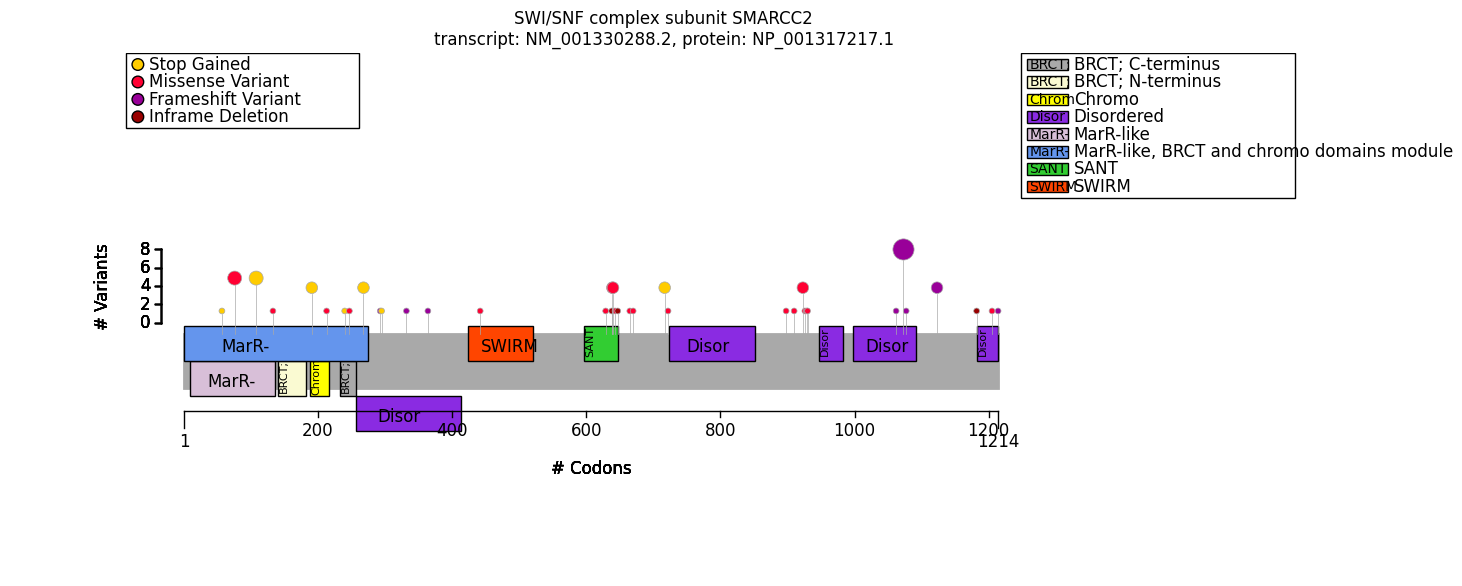

In [45]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [46]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

frameshift_pred= VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, mane_tx_id)
splice = VariantPredicates.variant_effect(VariantEffect.SPLICE_REGION_VARIANT, mane_tx_id)

gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(frameshift_pred | splice)

/var/folders/wf/3t934whj4b99bql00wxk8c2c0000gn/T/ipykernel_46322/966836801.py:9: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(frameshift_pred | splice)


In [47]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [48]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

In [49]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [50]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [51]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,39
HMF04,Skipping term because all genotypes have same HPO observed proportions,70
HMF06,Skipping term with less than 7 observations (not powered for 2x2),75
HMF08,Skipping general term,53


In [52]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                        HOM_REF            HET  \
                                                    Count Percent  Count   
Intellectual disability [HP:0001249]                38/39     97%  12/19   
Moderate global developmental delay [HP:0011343]    15/39     38%   1/19   
Thick lower lip vermilion [HP:0000179]              15/37     41%   2/19   
Prominent forehead [HP:0011220]                      6/30     20%   8/17   
Anteverted nares [HP:0000463]                        9/36     25%   1/19   
Thick nasal alae [HP:0009928]                       12/35     34%   3/19   
Joint hypermobility [HP:0001382]                     4/37     11%   4/17   
Feeding difficulties [HP:0011968]                   21/37     57%   7/19   
Failure to thrive [HP:0001508]                      21/39     54%   7/19   
Downslanted palpebral fissures [HP:0000494]          6/34     18%   6/18   
Hypotonia [HP:0001252]                              25/39     64%  15/19   
Autistic behavior [HP:0000729]                      11/38     29%   9/21   
EEG abnormality [HP:0002353]                         6/20     30%   2/13   
Strabismus [HP:0000486]                              9/35     26%   2/16   
Hypertonia [HP:0001276]                              6/38     16%   5/19   
Short stature [HP:0004322]                          10/36     28%   3/17   
Broad philtrum [HP:0000289]                         11/32     34%   4/18   
Long eyelashes [HP:0000527]                         12/36     33%   4/19   
Reduced cerebral white matter volume [HP:0034295]    2/24      8%   2/10   
Thin upper lip vermilion [HP:0000219]               17/37     46%   7/19   
Low-set ears [HP:0000369]                            8/32     25%   3/16   
Short philtrum [HP:0000322]                         10/33     30%   5/18   
Sleep abnormality [HP:0002360]                       7/36     19%   4/19   
Thick eyebrow [HP:0000574]                          14/37     38%   7/19   
Severe global developmental delay [HP:0011344]       9/39     23%   4/19   
Seizure [HP:0001250]                                11/39     28%   5/18   
Decreased body weight [HP:0004325]                  23/25     92%    8/8   
Mild global developmental delay [HP:0011342]        14/39     36%   7/19   
Wide nose [HP:0000445]                               9/35     26%   5/19   

What is the genotype group                                                    \
                                                  Percent Corrected p values   
Intellectual disability [HP:0001249]                  63%           0.030875   
Moderate global developmental delay [HP:0011343]       5%           0.156805   
Thick lower lip vermilion [HP:0000179]                11%           0.297155   
Prominent forehead [HP:0011220]                       47%           0.688182   
Anteverted nares [HP:0000463]                          5%           0.803496   
Thick nasal alae [HP:0009928]                         16%           0.837967   
Joint hypermobility [HP:0001382]                      24%           0.837967   
Feeding difficulties [HP:0011968]                     37%           0.837967   
Failure to thrive [HP:0001508]                        37%           0.837967   
Downslanted palpebral fissures [HP:0000494]           33%           0.837967   
Hypotonia [HP:0001252]                                79%           0.837967   
Autistic behavior [HP:0000729]                        43%           0.837967   
EEG abnormality [HP:0002353]                          15%           0.837967   
Strabismus [HP:0000486]                               12%           0.837967   
Hypertonia [HP:0001276]                               26%           0.837967   
Short stature [HP:0004322]                            18%           0.837967   
Broad philtrum [HP:0000289]                           22%           0.837967   
Long eyelashes [HP:0000527]                           21%           0.837967   
Reduced cerebral white matter volume [HP:00

In [53]:
missense_stop_gained_pred = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id) and  VariantPredicates.variant_effect(VariantEffect.STOP_GAINED, mane_tx_id)
splice = VariantPredicates.variant_effect(VariantEffect.SPLICE_REGION_VARIANT, mane_tx_id)

gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(missense_stop_gained_pred | splice)

/var/folders/wf/3t934whj4b99bql00wxk8c2c0000gn/T/ipykernel_46322/1924403917.py:4: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(missense_stop_gained_pred | splice)


In [54]:
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)


In [55]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [56]:
viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,39
HMF04,Skipping term because all genotypes have same HPO observed proportions,68
HMF05,Skipping term because one genotype had zero observations,1
HMF06,Skipping term with less than 7 observations (not powered for 2x2),75
HMF08,Skipping general term,53


In [57]:
report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                       HOM_REF            HET  \
                                                   Count Percent  Count   
Mild global developmental delay [HP:0011342]        7/40     18%  14/18   
Moderate global developmental delay [HP:0011343]   15/40     38%   1/18   
Hypotonia [HP:0001252]                             32/40     80%   8/18   
Decreased body weight [HP:0004325]                 24/24    100%    7/9   
Short stature [HP:0004322]                         12/37     32%   1/16   
Autistic behavior [HP:0000729]                     17/41     41%   3/18   
Joint hypermobility [HP:0001382]                    3/37      8%   5/17   
Failure to thrive [HP:0001508]                     22/40     55%   6/18   
Prominent forehead [HP:0011220]                    12/32     38%   2/15   
Broad philtrum [HP:0000289]                        12/33     36%   3/17   
Wide mouth [HP:0000154]                             7/33     21%   1/17   
Severe global developmental delay [HP:0011344]     11/40     28%   2/18   
Wide nose [HP:0000445]                             11/36     31%   3/18   
Feeding difficulties [HP:0011968]                  22/40     55%   6/16   
Intellectual disability [HP:0001249]               33/40     82%  17/18   
EEG abnormality [HP:0002353]                        6/20     30%   2/13   
Anteverted nares [HP:0000463]                       8/37     22%   2/18   
Strabismus [HP:0000486]                             9/36     25%   2/15   
Thick nasal alae [HP:0009928]                       9/36     25%   6/18   
Long eyelashes [HP:0000527]                        12/37     32%   4/18   
Seizure [HP:0001250]                               10/39     26%   6/18   
Sleep abnormality [HP:0002360]                      7/38     18%   4/17   
Low-set ears [HP:0000369]                           8/32     25%   3/16   
Short philtrum [HP:0000322]                        11/34     32%   4/17   
Scoliosis [HP:0002650]                             11/39     28%   4/18   
Thick lower lip vermilion [HP:0000179]             11/38     29%   6/18   
Thick eyebrow [HP:0000574]                         15/38     39%   6/18   
Thin upper lip vermilion [HP:0000219]              16/38     42%   8/18   
Downslanted palpebral fissures [HP:0000494]         8/35     23%   4/17   
Hypertonia [HP:0001276]                             8/39     21%   3/18   

What is the genotype group                                                   \
                                                 Percent Corrected p values   
Mild global developmental delay [HP:0011342]         78%           0.000541   
Moderate global developmental delay [HP:0011343]      6%           0.127702   
Hypotonia [HP:0001252]                               44%           0.127702   
Decreased body weight [HP:0004325]                   78%           0.394089   
Short stature [HP:0004322]                            6%           0.394089   
Autistic behavior [HP:0000729]                       17%           0.394089   
Joint hypermobility [HP:0001382]                     29%           0.394089   
Failure to thrive [HP:0001508]                       33%           0.565929   
Prominent forehead [HP:0011220]                      13%           0.565929   
Broad philtrum [HP:0000289]                          18%           0.626594   
Wide mouth [HP:0000154]                               6%           0.647538   
Severe global developmental delay [HP:0011344]       11%           0.767092   
Wide nose [HP:0000445]                               17%           0.779016   
Feeding difficulties [HP:0011968]                    38%           0.779016   
Intellectual disability [HP:0001249]                 94%           0.779016   
EEG abnormality [HP:0002353]                         15%           0.779016   
Anteverted nares [HP:0000463]                        11%           0.779016   
Strabismus [HP:0000486]                              13%           0.779016   
Thick nasal alae [H

In [60]:
# 12_56165327_56165328_CA_C
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
is_var_key = VariantPredicates.variant_key("12_56165327_56165328_CA_C")

gt_predicate = monoallelic_predicate(
    a_predicate=is_var_key,
    b_predicate= ~is_var_key,
    names=('p.Gly1075AspfsTer17', 'Other variant')
)
gt_predicate.display_question()

TypeError: unhashable type: 'InvVariantPredicate'

### for Region MarR-like, BRCT and chromo domains module	region	1 - 274	

In [61]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

nterm_region = Region(start=1, end=274)
is_n_term = VariantPredicates.region(region=nterm_region, tx_id=mane_tx_id)

gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(is_n_term)

/var/folders/wf/3t934whj4b99bql00wxk8c2c0000gn/T/ipykernel_46322/1168940851.py:9: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(is_n_term)


In [62]:
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [63]:
mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [64]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [65]:
viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,39
HMF04,Skipping term because all genotypes have same HPO observed proportions,68
HMF05,Skipping term because one genotype had zero observations,1
HMF06,Skipping term with less than 7 observations (not powered for 2x2),75
HMF08,Skipping general term,53


In [66]:
report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                       HOM_REF            HET  \
                                                   Count Percent  Count   
Mild global developmental delay [HP:0011342]       10/43     23%  11/15   
Severe global developmental delay [HP:0011344]     13/43     30%   0/15   
Hypotonia [HP:0001252]                             33/43     77%   7/15   
Prominent forehead [HP:0011220]                    13/34     38%   1/13   
Wide nose [HP:0000445]                             13/39     33%   1/15   
Short stature [HP:0004322]                         12/38     32%   1/15   
Sleep abnormality [HP:0002360]                      6/41     15%   5/14   
Thin upper lip vermilion [HP:0000219]              15/41     37%   9/15   
Failure to thrive [HP:0001508]                     23/43     53%   5/15   
Strabismus [HP:0000486]                            10/38     26%   1/13   
Feeding difficulties [HP:0011968]                  23/42     55%   5/14   
Thick eyebrow [HP:0000574]                         17/41     41%   4/15   
Decreased body weight [HP:0004325]                 25/26     96%    6/7   
Joint hypermobility [HP:0001382]                    5/40     12%   3/14   
Low-set ears [HP:0000369]                           9/34     26%   2/14   
Broad philtrum [HP:0000289]                        12/36     33%   3/14   
Thick lower lip vermilion [HP:0000179]             14/41     34%   3/15   
Thick nasal alae [HP:0009928]                      12/39     31%   3/15   
Moderate global developmental delay [HP:0011343]   13/43     30%   3/15   
Autistic behavior [HP:0000729]                     16/44     36%   4/15   
Intellectual disability [HP:0001249]               36/43     84%  14/15   
Hypertelorism [HP:0000316]                          5/38     13%   3/14   
EEG abnormality [HP:0002353]                        6/21     29%   2/12   
Anteverted nares [HP:0000463]                       8/40     20%   2/15   
Short philtrum [HP:0000322]                        11/37     30%   4/14   
Scoliosis [HP:0002650]                             11/42     26%   4/15   
Long eyelashes [HP:0000527]                        12/40     30%   4/15   
Seizure [HP:0001250]                               12/42     29%   4/15   
Downslanted palpebral fissures [HP:0000494]         9/38     24%   3/14   
Hypertonia [HP:0001276]                             8/42     19%   3/15   

What is the genotype group                                                   \
                                                 Percent Corrected p values   
Mild global developmental delay [HP:0011342]         73%           0.035375   
Severe global developmental delay [HP:0011344]        0%           0.206430   
Hypotonia [HP:0001252]                               47%           0.400632   
Prominent forehead [HP:0011220]                       8%           0.400632   
Wide nose [HP:0000445]                                7%           0.400632   
Short stature [HP:0004322]                            7%           0.400632   
Sleep abnormality [HP:0002360]                       36%           0.518904   
Thin upper lip vermilion [HP:0000219]                60%           0.518904   
Failure to thrive [HP:0001508]                       33%           0.749668   
Strabismus [HP:0000486]                               8%           0.749668   
Feeding difficulties [HP:0011968]                    36%           0.820585   
Thick eyebrow [HP:0000574]                           27%           0.820585   
Decreased body weight [HP:0004325]                   86%           0.820585   
Joint hypermobility [HP:0001382]                     21%           0.820585   
Low-set ears [HP:0000369]                            14%           0.820585   
Broad philtrum [HP:0000289]                          21%           0.820585   
Thick lower lip vermilion [HP:0000179]               20%           0.820585   
Thick nasal alae [HP:0009928]                        20%           0.820585   
Moderate global dev